In [2]:
from sklearn.datasets import load_iris,load_diabetes
from sklearn.model_selection import train_test_split
from scipy import stats
import numpy as np 
from matplotlib import pyplot as plt
import math
import os 

### Intuition 
***
a random forest uses baging and combines many desicion trees to one big estimate. Each individual tree is constructed randomly: on random sample of input points and by selecting the spliting point from a random subset of all dimensions.
</br>

### Algorithm
***
for $b=1$ to $B$ </br>
- Draw a bootstrap sample Z of size N from the training data
- Gro a random forest tree $T_{b}$ to the bootstrapped data, by recursively repeating the following steps for each terminal node of the tree, until the minimum node size $n_{min}$ is reached 
  - Select m variables randomly from the p variables
  - Select the best variable/split-point among the m
  - Split the node into two daughter nodes
  
Output the ensambles of tree model $\{T_{b}\}_{1}^{B}$ </br>
To make a prediction at the new point $x$: </br>
$\quad$ Regression: $f(x) = \frac{\sum_{1}^{B} T_{b}}{B}$</br>
$\quad$ classification: $f(x) = argmax(T_{b})$

### Parameters
***
The size of the subsample: reasonably large; can be with or without replacement (in the latter case, one often chooses the subsample size equal to the size of the original sample). The number m of dimensions of which we pick the be one: Typically, people choose something around $d/3$ where ber d is the original dim of the data. The number B of trees should be large. The number $n_{min}$ of points in the leaves: depends on whether you consider deep or shallow trees. In the extreme case of deep trees, $n_{min} = 1$ Then you need many trees B. In the case of shallow trees, $n \approx log(n)$


### Consistency of random ferest
***
On a high level, here are the main results:
- A single spatial decision tree is consistent if the diameter of all cell converges to 0 and at the same time, the number of points in each of the cells tends to infinity, as the number n of the data points goes to infinity 
- If all individual trees are consistent, so is the random forest 
- Curiously, a random forest can be consistent even if all its trees are not consistent. This is particularly the case for deep trees.

In [16]:
X, Y, _, desc, feature_names, _, _ = load_iris().values()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [135]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf(self):
        return self.value is not None
        
                      
        
class DesicionTree:
    
    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.criteria = dict(
            gini = lambda y: np.sum([np.log2(p) * p for p in np.bincount(y) / len(y) if p > 0]),
            l2   = lambda x: x,
        )
    
    def fit(self, X, y, sample_size=1):
        self.root = self._build_tree(X, y.ravel(), sample_size)
        return self
        
    def _information_gain(self, n, total_loss, n_left, left_loss, n_rigth, right_loss):
        # Calculate information gain
        if n_left == 0 or n_rigth == 0: 
            return 0
        return total_loss - ((n_left / n) * left_loss + (n_rigth / n) * right_loss)
    
    def _create_split(self, data, split):
        # Split data based on split point
        left_idx = np.argwhere(data <= split).flatten()
        right_idx = np.argwhere(data > split).flatten()
        return left_idx, right_idx
        
    
    def _get_split(self, X, y, sample_size, criteria='gini'):
        score = []      
        total_loss = self.criteria[criteria](y)
        features = np.random.choice(X.shape[1], size= math.ceil(X.shape[1] * sample_size), replace=False)
        for dimension, data in zip(features, X[:, features].T):
            for split in np.unique(data):
                # Get indices of each group given the split
                left_idx, right_idx = self._create_split(data, split)

                # Get loss of each group given the split
                left_loss = self.criteria[criteria](y[left_idx])
                right_loss = self.criteria[criteria](y[right_idx])
                
                # Calculate information gain
                ig = self._information_gain(len(y) ,total_loss, len(left_idx), left_loss, len(right_idx), right_loss)
                score.append((ig, dimension, split))   
                
        return min(score, key = lambda e: e[0])
    
    
    def _build_tree(self, X, y, sample_size, depth=0):
        self.n_samples, self.n_features = X.shape
        self.n_class_labels = len(np.unique(y))
        
        (ig, dimension, split) = self._get_split(X, y, sample_size)
        left_idx, right_idx = self._create_split(X[:, dimension], split)
        
        # stopping criteria
        if (depth >= self.max_depth 
            or self.n_class_labels == 1 
            or self.n_samples < self.min_samples_split
            or len(left_idx) == 0 
            or len(right_idx) == 0      
           ):
            most_common_Label = np.argmax(np.bincount(y))       
            return Node(value=most_common_Label)
        else:
            left_child = self._build_tree(X[left_idx, :], y[left_idx], sample_size, depth + 1)
            right_child = self._build_tree(X[right_idx, :], y[right_idx], sample_size, depth + 1)
            return Node(feature=dimension, threshold=split, left=left_child, right=right_child)

    def _traverse_tree(self, x, node):
        if node.is_leaf(): 
            return node.value  
        if x[node.feature] <= node.threshold: 
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
            
    def predict(self, X):
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)
    
    

    
class RandomForest:
    
    def __init__(self, size=1, max_depth=200, min_samples_split=2, sample_data_proportion=1, sample_dimension_proportion = 1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.size = size
        
        self.sample_data_proportion = sample_data_proportion
        self.sample_dimension_proportion = sample_dimension_proportion
        
    def fit(self, X, y):
        self.trees = [ DesicionTree() for _ in range(self.size)] 
        
        for tree in self.trees: 
            sample_size = math.ceil(X.shape[0] * self.sample_data_proportion)
            X_sample_idx = np.random.choice(X.shape[0], size=sample_size, replace=False)
            X_sample = X[X_sample_idx, :]
            y_sample = y[X_sample_idx]
            tree.fit(X_sample, y_sample, sample_size=self.sample_dimension_proportion)
            
        return self
    
    def predict(self, X):
        y = []
        predictions = []
        for tree in self.trees: 
            prediction = tree.predict(X)
            predictions.append(prediction)
            
        for prediction_i in np.array(predictions).T:
            y.append(np.argmax(np.bincount(prediction_i)))
        return np.array(y)
        
 
            
            
    
model = RandomForest(size=100, sample_data_proportion=1/3, sample_dimension_proportion=1/3);
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print( np.sum(y_test == y_predict) / len(y_test))

0.98


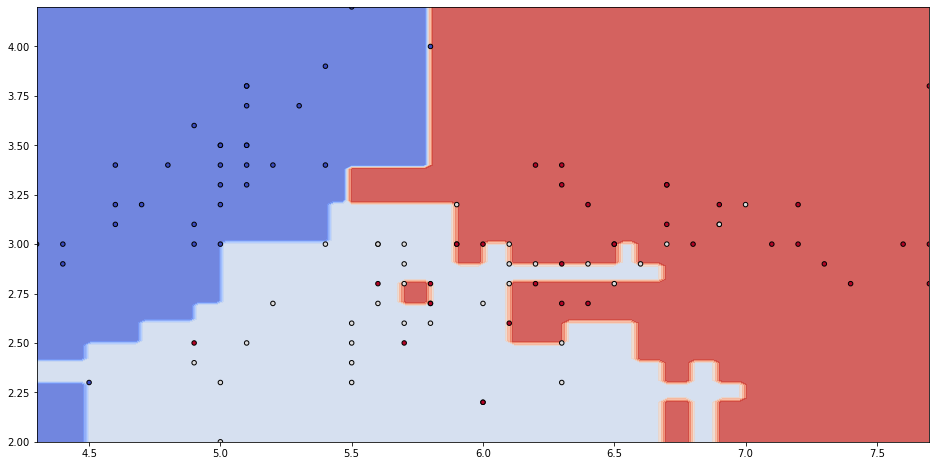

In [140]:
model = RandomForest(size=100, sample_data_proportion=1/3, sample_dimension_proportion=1/3)

fig, axis = plt.subplots(1, 1, figsize=(16,8), sharey=True)

x1_min, x2_min, x3_min, x4_min = np.min(X_train, axis=0)
y1_min, y2_min, y3_min, y4_min = np.max(X_train, axis=0)

xx, yy = np.meshgrid(np.linspace(x1_min, y1_min, 100), np.linspace(x2_min, y2_min, 100))
Z = model.fit(X_train[:, [0,1]], y_train).predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

axis.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8);
axis.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k');
